In [2]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers
from keras.regularizers import l1
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


### Intro to Modern Neural Network Architectures

- Types of Networks
	- Classification
	- Regression (predict a continuous number)
		- Predict housing prices
		- Time series
    - Generative (won't be discussing)
    
Won't be covering how a neural network "learns" - there's a good 3B1B series on youtube if you're curious - but instead looking at the common and fundamental architectures in use today. This is to get a sense of what's truly possible with deep learning and gain familiarity with the tools and concepts.

We also assume a familiarity with what a single neuron does in a neural network. To refresh, it takes in a series of inputs, scales each input by some number, adds the scaled inputs together, and passes it through a non-linear function as output (also known as activation). The values which you scale an input are learned parameters trained via the data, and the non-linear function (also known as activation function) is a design parameter we must pick.

*This week*
- Classification
    - Neural Networks
    - Working with Keras, Fashion-MNIST
	- Mathematical Convolution
	- Image Convolution
	- Convolution for image classification (CNNs)

*Next Week*

- Regression
	- Language, Music processing
	- RNNs
	- Limitations of RNNs, vanishing gradient
	
- LSTMs
	- Solves vanishing gradient problem
	- A more robust language model
	- Music Synthesis / Generation
    
  

# Classification

Given an input, what class does it belong to?

- Given a handwritten digit, what number is it?
- Does a picture contain a dog?

Final Layer typically has as many neurons as classes (N)

![title](img/Final_layer.svg)

For example, each of the 1..N ending neurons could represent a digit if we were doing handwritten-digit recognition. In such a scenario, we would have ten neurons in the final layer, each representing digits 0-9

Lets just focus on the final layer fist, and then explore the rest later


## Choosing an Activation function - Softmax
We want the neuron firing most intensely in the final layer to indicate the answer. We could just simply take the most intensly firing neuron and return that as our answer, but we wouldn't have two properties we desire, namely:
 1. Our answer should represent a probability distribution
 2. It should separate extreme values
 
For example, if we feed in a picture of a handwritten number three, we expect the 3rd neuron in the final layer to be the most active. But we also want the amount of activation to indicate how confident the network's prediction is (1). It's activation relative to other neurons is also important (2).
<br><br>
The softmax function achieves this
$$softmax(a_i)=\frac{e^{a_i}}{{\sum_{k=0}^{N}e^{a_k}}} \quad where\ i\ is\ in\ range\ 0..N$$

In [272]:
# Notice that the softmax returns an all positive array which sums to one
# which you can thus interpret as a probability distribution

# It also seperates out extreme values, so if you had the array below, the entry with 19
# seems much more likely to be the correct answer than the entries with 9, even if the absolute difference is just 10

def softmax(x):
    """Where x is an array of numbers"""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

activations = [9,9,9,19,9,9,9,9,9,9]
result = softmax(activations)
print(result)
print(sum(result))

[0.03438135 0.03438135 0.03438135 0.69056786 0.03438135 0.03438135
 0.03438135 0.03438135 0.03438135 0.03438135]
1.0000000000000002


In [10]:
model = Sequential()
'''
--- We'll add input layer later
--- We'll add hidden layers later
'''
model.add(Dense(10, activation="softmax"))

### Fashion-MNIST
Lets look at some data before designing the rest of our neural network

In [228]:
#Load data

from keras.datasets import fashion_mnist

#Load data
(x_train_, y_train_), (x_test_, y_test_) = fashion_mnist.load_data()

#Format data for our naive attempt
x_train_naive = x_train_.reshape(x_train_.shape[0], 784)
x_test_naive = x_test_.reshape(x_test_.shape[0], 784)

#Format data for CNN attempt
x_train = x_train_.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test_.reshape((x_test.shape[0], 28, 28, 1))

#Turn numbers to one-hot vectors
y_train = keras.utils.to_categorical(y_train_)
y_test = keras.utils.to_categorical(y_test_)

print("There are ", len(x_train), " training examples in this dataset")
print("There are ", len(x_test), " test examples in this dataset")

There are  60000  training examples in this dataset
There are  10000  test examples in this dataset


This is labelled:  3


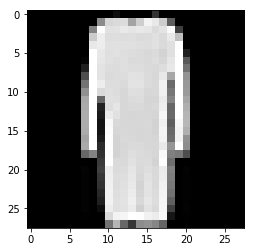

In [230]:
example = 25
plt.imshow(x_train_[example], cmap='gray')
print("This is labelled: ", y_train_[example])

| Label | Description |
|-------|-------------|
| 0     | T-shirt/top |
1 |	Trouser
2 |	Pullover
3 |	Dress
4 |	Coat
5 |	Sandal
6 |	Shirt
7 |	Sneaker
8 |	Bag
9 |	Ankle boot

#### Let's just try a bunch of different architectures

In [75]:
#Define Model

model = Sequential()

#Mess around with the parameters below
#Add or remove dense layers
#Change the number of neurons in each layer
#Change the activations
#Do not change the input shape, however
model.add(Dense(20, activation="sigmoid", input_shape=(784,)))
model.add(Dense(10, activation="sigmoid"))

#Dont change the last layer! We need a softmax with 10 Neurons!
model.add(Dense(10, activation="softmax")) 

#You must compile a model before you actually do anything with it
#It lets the model variable know you're done messing with it
#and checks for conflicts in your design.
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Some clarifications
**Activation Functions** <br>
Technically any function can be an activation function, but the common ones (and built into keras) are
- Sigmoid: Squish values between 0 and 1
- Tanh: Squish values between -1 and 1
- ReLu: Turn negative values to 0 ; max(0, x)
- Softmax: Used as final layer of classification
- Linear: Used as final layer of regression
   
**Model Compilation**
 - Optimizer: Not conceptually important, just makes it run faster but rearranging some of the math
 - Loss: The function which tells the model how well it's doing
   - Categorical Crossentropy: Typically used for classification problems
   - Squared Error Loss: Typically used for regression problems 
   - There are others but applications are niche
 - Metrics: The function which tell us (humans) how well something's doing
   - Basically just accuracy, used when doing classification. 
     - We can't use accuracy during classification as a loss function as it's not differentiable 

In [69]:
history = model.fit(x_train_naive, y_train, 
                    #Epochs are num times we rinse through the whole dataset
                    #Batch size is how many datapoints do we load into memory at any given time. This can affect model results
                    epochs=50, batch_size=32, 
                    #How we can evaluate the model's ability to generalize
                    validation_data=(x_test_naive, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/500
60000/60000 [==============================] - 2s 37us/step - loss: 1.6518 - acc: 0.4285 - val_loss: 1.2207 - val_acc: 0.5047
Epoch 2/500
60000/60000 [==============================] - 2s 32us/step - loss: 1.0803 - acc: 0.5981 - val_loss: 1.0006 - val_acc: 0.6510
Epoch 3/500
60000/60000 [==============================] - 2s 33us/step - loss: 0.9657 - acc: 0.6471 - val_loss: 0.9254 - val_acc: 0.6445
Epoch 4/500
60000/60000 [==============================] - 2s 32us/step - loss: 0.8498 - acc: 0.6839 - val_loss: 0.8248 - val_acc: 0.7002
Epoch 5/500
60000/60000 [==============================] - 2s 32us/step - loss: 0.8208 - acc: 0.6920 - val_loss: 0.8362 - val_acc: 0.6807
Epoch 6/500
60000/60000 [==============================] - 2s 33us/step - loss: 0.7950 - acc: 0.7007 - val_loss: 0.8179 - val_acc: 0.6891
Epoch 7/500
60000/60000 [==============================] - 2s 32us/step - loss: 0.7896 - acc: 0.7029 - val_loss: 0.8008 - 

Epoch 118/500
60000/60000 [==============================] - 2s 30us/step - loss: 0.6076 - acc: 0.7906 - val_loss: 0.6507 - val_acc: 0.7783
Epoch 119/500
60000/60000 [==============================] - 2s 30us/step - loss: 0.6087 - acc: 0.7898 - val_loss: 0.6579 - val_acc: 0.7441
Epoch 120/500
60000/60000 [==============================] - 2s 30us/step - loss: 0.5790 - acc: 0.7909 - val_loss: 0.6179 - val_acc: 0.7730
Epoch 121/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.5840 - acc: 0.7930 - val_loss: 0.6463 - val_acc: 0.7648
Epoch 122/500
60000/60000 [==============================] - 2s 30us/step - loss: 0.5875 - acc: 0.7950 - val_loss: 0.6112 - val_acc: 0.7934
Epoch 123/500
60000/60000 [==============================] - 2s 31us/step - loss: 0.5746 - acc: 0.7926 - val_loss: 0.6099 - val_acc: 0.7782
Epoch 124/500
60000/60000 [==============================] - 2s 30us/step - loss: 0.5767 - acc: 0.7932 - val_loss: 0.6575 - val_acc: 0.7609
Epoch 125/500
60000/

60000/60000 [==============================] - 2s 30us/step - loss: 0.5378 - acc: 0.8108 - val_loss: 0.6039 - val_acc: 0.7871
Epoch 235/500
60000/60000 [==============================] - 2s 30us/step - loss: 0.5691 - acc: 0.7929 - val_loss: 0.6053 - val_acc: 0.7905
Epoch 236/500
60000/60000 [==============================] - 2s 30us/step - loss: 0.5617 - acc: 0.8113 - val_loss: 0.6030 - val_acc: 0.7873
Epoch 237/500
60000/60000 [==============================] - 2s 31us/step - loss: 0.5507 - acc: 0.8073 - val_loss: 0.6297 - val_acc: 0.7729
Epoch 238/500
60000/60000 [==============================] - 2s 31us/step - loss: 0.5846 - acc: 0.7823 - val_loss: 0.6310 - val_acc: 0.7676
Epoch 239/500
60000/60000 [==============================] - 2s 30us/step - loss: 0.5801 - acc: 0.7978 - val_loss: 0.6020 - val_acc: 0.7956
Epoch 240/500
60000/60000 [==============================] - 2s 30us/step - loss: 0.5574 - acc: 0.8062 - val_loss: 0.5802 - val_acc: 0.8097
Epoch 241/500
60000/60000 [=======

60000/60000 [==============================] - 2s 37us/step - loss: 0.5266 - acc: 0.8189 - val_loss: 0.5895 - val_acc: 0.7993
Epoch 351/500
60000/60000 [==============================] - 2s 33us/step - loss: 0.5172 - acc: 0.8184 - val_loss: 0.5564 - val_acc: 0.8145
Epoch 352/500
60000/60000 [==============================] - 2s 33us/step - loss: 0.5133 - acc: 0.8258 - val_loss: 0.5629 - val_acc: 0.8083
Epoch 353/500
60000/60000 [==============================] - 2s 32us/step - loss: 0.5222 - acc: 0.8195 - val_loss: 0.5730 - val_acc: 0.8054
Epoch 354/500
60000/60000 [==============================] - 2s 32us/step - loss: 0.5162 - acc: 0.8273 - val_loss: 0.5659 - val_acc: 0.8050
Epoch 355/500
60000/60000 [==============================] - 2s 33us/step - loss: 0.5198 - acc: 0.8212 - val_loss: 0.5731 - val_acc: 0.8096
Epoch 356/500
60000/60000 [==============================] - 2s 33us/step - loss: 0.5227 - acc: 0.8190 - val_loss: 0.5627 - val_acc: 0.8070
Epoch 357/500
60000/60000 [=======

60000/60000 [==============================] - 2s 33us/step - loss: 0.5097 - acc: 0.8316 - val_loss: 0.5511 - val_acc: 0.8087
Epoch 467/500
60000/60000 [==============================] - 2s 33us/step - loss: 0.4991 - acc: 0.8279 - val_loss: 0.5476 - val_acc: 0.8160
Epoch 468/500
60000/60000 [==============================] - 2s 33us/step - loss: 0.5401 - acc: 0.8163 - val_loss: 0.5618 - val_acc: 0.8038
Epoch 469/500
60000/60000 [==============================] - 2s 34us/step - loss: 0.5169 - acc: 0.8216 - val_loss: 0.5532 - val_acc: 0.8150
Epoch 470/500
60000/60000 [==============================] - 2s 33us/step - loss: 0.5049 - acc: 0.8277 - val_loss: 0.5527 - val_acc: 0.8105
Epoch 471/500
60000/60000 [==============================] - 2s 34us/step - loss: 0.5147 - acc: 0.8144 - val_loss: 0.5669 - val_acc: 0.8052
Epoch 472/500
60000/60000 [==============================] - 2s 33us/step - loss: 0.5128 - acc: 0.8193 - val_loss: 0.5587 - val_acc: 0.8102
Epoch 473/500
60000/60000 [=======

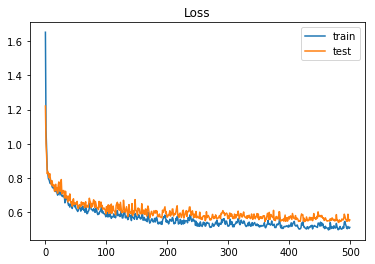

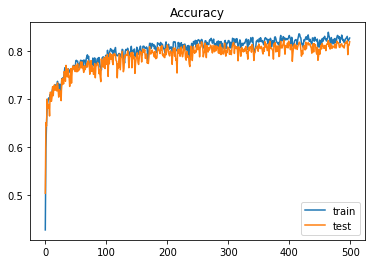

In [70]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.title("Loss")
plt.legend()

plt.figure()

plt.plot(history.history["acc"], label="train")
plt.plot(history.history["val_acc"], label="test")
plt.title("Accuracy")
plt.legend()

In [72]:
model.count_params()

16020

### Notice how the accuracy picks up after 100 or so epochs, and even then caps out at around 80%. With 16000 parameters to tune, could we not do better?

# Convolutions
In mathematics and signal processing, convolutions are sometimes called "filters" or "detectors". It is an operation which can prune through a series of data and pick out certain things. 

![title](img/conv_def2.png)


Thats hard to read, so lets see an example. 

![title](img/1D_Convolution.png)

Let's look at a more hands on example below

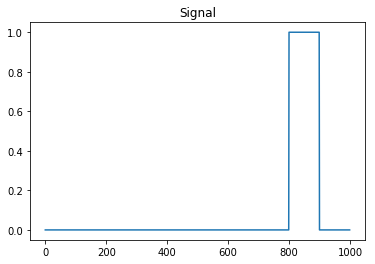

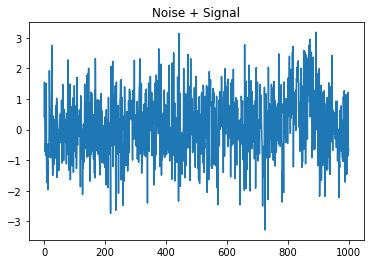

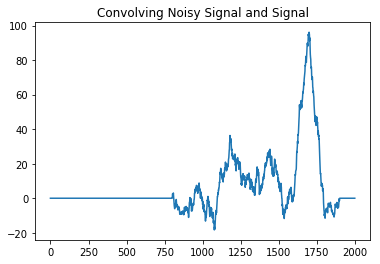

In [3]:
import numpy as np
import matplotlib.pyplot as plt

n=1000

signal = np.zeros(n)
signal[800:900] = 1

noise = np.random.normal(0,1,n)

noisy_signal = noise + signal

convolution = np.convolve(noisy_signal, signal)

plt.title("Signal")
plt.plot(signal)
plt.figure()
plt.title("Noise + Signal")
plt.plot(noise+signal)
plt.figure()
plt.title("Convolving Noisy Signal and Signal")
plt.plot(convolution)

If we have noise added to our signal, we can recover where the original signal most likely occured by convolving the noisy signal with the clean, or reference, signal. In fact, this is the principle behind sonar and radar where they send out a reference signal and it comes back super noisy but they can still recover where the original signal was deflected from.

# 2D Convolution
The principle scales to two dimensions, which is especially useful for us when doing image classification

![title](img/2D_conv.png)


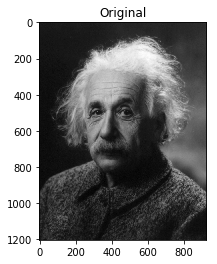

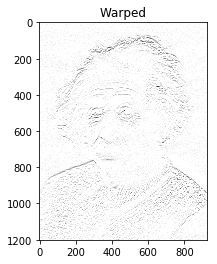

In [4]:
from PIL import Image
from scipy import signal as sg
from skimage import color

img = np.asarray(Image.open("img/einstein.jpeg").convert(), dtype=np.float32)
img = color.rgb2gray(img)

#Horizontal Edge Detector
# kernal = [[-10, 0 , 10]]

#Verticle Edge Detector
kernal = [[-10],
          [0],
          [10]]


new_img = sg.convolve(img, kernal, "valid")

#Non-linearity, we'll get to this in a bit
new_img = new_img * (new_img < 0)

plt.title("Original")
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.figure()
plt.title("Warped")
plt.imshow(new_img, cmap=plt.get_cmap('gray'))

In [ ]:
#Other fun kernals to try:

kernal = [[-1, 0, -1]
         ,[-8, 0, 8]
         ,[-1, 0, -1]]

kernal = [[-1, 0, 1]
         ,[-8, 0, 8]
         ,[-1, 0, -1]]

kernal = [[-1, 0, 1]
         ,[-8, 0, -8]
         ,[-1, 0, -1]]

# Relation to Neural Networks
If we could define a kernal which picks out features, say the "dog kernal" which lights up whenever it passes over a dog, then we could use **convolutional layers** within our neural network for image classification. So if after passing our dog kernal over an image and we get a very "bright" image, theres a good chance a dog exists in our photo.

The convolutional layers, which act like detectors (or filters) passing over an image are implemented as follows:
![image](img/conv_layers.png)

We then apply a non-linearity, most often a ReLu function, `max(x, 0)` - although this aspect is poorly understood theoretically, turns out it just works.

Then we pool together groups of pixels to summarize our findings and abstract our representation. This is typically done via **max-pooling**, that is, reducing a group of pixels to the one that is maximally triggered

![image](img/full_conv.png)

### Visualizing convolutional layers

In fact, the first few layers of a convolutional neural network are edge detectors

![image](img/first_layers.png)

And uppper level layers start to pick up on more abstract representations. We can even start to see a "dog kernal"

![image](img/upper_layers.png)


In [222]:
cnn = Sequential()

cnn.add(Conv2D(20, kernel_size=(5, 5), activation='relu', input_shape=(28,28,1)))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Conv2D(10, kernel_size=(3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Flatten())
cnn.add(Dense(10, activation='softmax'))


cnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

cnn.count_params()

4840

In [223]:
cnn_history = cnn.fit(x_train, y_train, 
                    #Epochs are num times we rinse through the whole dataset
                    #Batch size is how many datapoints do we load into memory at any given time. This can affect model results
                    epochs=50, batch_size=32, 
                    #How we can evaluate the model's ability to generalize
                    validation_data=(x_test, y_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 21s 348us/step - loss: 2.1639 - acc: 0.6642 - val_loss: 0.5806 - val_acc: 0.7900
Epoch 2/50
60000/60000 [==============================] - 19s 320us/step - loss: 0.5248 - acc: 0.8107 - val_loss: 0.5869 - val_acc: 0.8030
Epoch 3/50
60000/60000 [==============================] - 19s 318us/step - loss: 0.4522 - acc: 0.8365 - val_loss: 0.4642 - val_acc: 0.8310
Epoch 4/50
60000/60000 [==============================] - 20s 342us/step - loss: 0.4162 - acc: 0.8486 - val_loss: 0.4466 - val_acc: 0.8371
Epoch 5/50
60000/60000 [==============================] - 20s 325us/step - loss: 0.3981 - acc: 0.8545 - val_loss: 0.4520 - val_acc: 0.8365
Epoch 6/50
60000/60000 [==============================] - 19s 317us/step - loss: 0.3838 - acc: 0.8602 - val_loss: 0.4077 - val_acc: 0.8532
Epoch 7/50
60000/60000 [==============================] - 20s 328us/step - loss: 0.3739 - acc: 0.8636 - val_loss: 0.

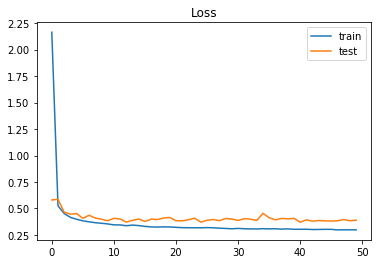

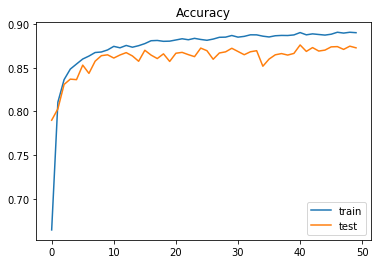

In [226]:
plt.plot(cnn_history.history["loss"], label="train")
plt.plot(cnn_history.history["val_loss"], label="test")
plt.title("Loss")
plt.legend()

plt.figure()

plt.plot(cnn_history.history["acc"], label="train")
plt.plot(cnn_history.history["val_acc"], label="test")
plt.title("Accuracy")
plt.legend()

This is labelled:  1


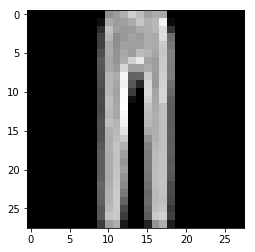

In [246]:
test_example = 24
plt.imshow(x_test_[test_example], cmap='gray')
print("This is labelled: ", y_test_[test_example])

| Label | Description |
|-------|-------------|
| 0     | T-shirt/top |
1 |	Trouser
2 |	Pullover
3 |	Dress
4 |	Coat
5 |	Sandal
6 |	Shirt
7 |	Sneaker
8 |	Bag
9 |	Ankle boot

In [247]:
prediction = np.argmax(cnn.predict([[x_test[test_example]]]))
print("Our model predicted: ", prediction)

Our model predicted:  1
